# 2_training_oxford-pet_ddp(Distributed Data Parallel)
---

본 모듈에서는 Amzaon SageMaker API을 효과적으로 이용하기 위해 multigpu-distributed 학습을 위한 PyTorch 프레임워크 기반 모델 훈련을 수행해 봅니다.

In [1]:
install_needed = True
# install_needed = False

In [2]:
import sys
import IPython

if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install --upgrade pip --quiet
    !{sys.executable} -m pip install -U wget split-folders --quiet
    IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel


## 1. Sagemaker notebook 설명
<p>Sagemaker notebook은 완전 관리형 서비스로 컨테이너 기반으로 구성되어 있습니다. 사용자가 직접 컨테이너를 볼 수 없지만, 내부적으로는 아래와 같은 원리로 동작합니다. </p>
<p><img src="./imgs/fig00.png" width="800", height="80"></p>

- **S3 (Simple Storage Serivce)** : Object Storage로서 학습할 데이터 파일과 학습 결과인 model, checkpoint, tensorboard를 위한 event 파일, 로그 정보 등을 저장하는데 사용합니다.
- **SageMaker Notebook** : 학습을 위한 스크립트 작성과 디버깅, 그리고 실제 학습을 수행하기 위한 Python을 개발하기 위한 환경을 제공합니다.
- **Amazon Elastic Container Registry(ECR)** :  Docker 컨테이너 이미지를 손쉽게 저장, 관리 및 배포할 수 있게 해주는 완전관리형 Docker 컨테이너 레지스트리입니다. Sagemaker는 기본적인 컨테이너를 제공하기 때문에 별도 ECR에 컨테이너 이미지를 등록할 필요는 없습니다. 하지만, 별도의 학습 및 배포 환경이 필요한 경우 custom 컨테이너 이미지를 만들어서 ECR에 등록한 후 이 환경을 활용할 수 있습니다.

<p>학습과 추론을 하는 hosting 서비스는 각각 다른 컨테이너 환경에서 수행할 수 있으며, 쉽게 다량으로 컨테이너 환경을 확장할 수 있으므로 다량의 학습과 hosting이 동시에 가능합니다.   
</p>

<p>Sagemaker 학습에 필요한 기본적인 package를 import 합니다. </p>
<p>boto3는 HTTP API 호출을 숨기는 편한 추상화 모델을 가지고 있고, Amazon EC2 인스턴스 및 S3 버켓과 같은 AWS 리소스와 동작하는 파이선 클래스를 제공합니다. </p>
<p>sagemaker python sdk는 Amazon SageMaker에서 기계 학습 모델을 교육 및 배포하기 위한 오픈 소스 라이브러리입니다.</p>

In [8]:
import os
import sagemaker
from pathlib import Path
from time import strftime

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [9]:
sagemaker.__version__

'2.169.0'

## Dataset 소개 및 split 후 S3 upload하기
<p>이번 학습에 사용할 이미지 데이터는 <strong><a href="https://www.robots.ox.ac.uk/~vgg/data/pets/" target="_blank" class ='btn-default'>Oxford-IIIT Pet Dataset</a></strong> 입니다. Oxford-IIIT Pet Dataset은 <strong>37</strong>개 다른 종의 개와 고양이 이미지를 각각 200장 씩 제공하고 있으며, Ground Truth 또한 Classification, Object Detection, Segmentation와 관련된 모든 정보가 있으나, 이번 학습에서는 37개 class에 대해 일부 이미지로 Classification 문제를 해결하기 위해 학습을 진행할 예정입니다.</p>
<p><img src="./imgs/pet_annotations.jpg" width="700", height="70"></p>    
<p>이미지 파일을 학습하기 위해 SageMaker Notebook 환경으로 upload를 합니다. 폴더 구조는 아래와 같은 형태로 구성되어야 합니다. </p>
<pre>
<div style='line-height:80%'>
    image_path/class1/Aimage_1<br>
                      Aimage_2<br>
                       ...<br>
                      Aimage_N<br>
    image_path/class2/Bimage_1<br>
                      Bimage_2<br>
                       ...<br>
                      Bimage_M<br>
</div>
</pre>

<p>SageMaker 학습을 위해 train/val로 분리한 폴더를 S3내 이전에 지정한 bucket 내 prefix 하위 폴더로 upload합니다. </p>

### Uploading the data to S3
We are going to use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use later when we start the training job.


In [10]:
def make_dir(img_path, delete=True):
    import shutil, os
    try:
        if not os.path.exists(img_path):
            os.makedirs(img_path)
        else:
            if delete:
                shutil.rmtree(img_path)
    except OSError:
        print("Error")

In [11]:
!rm -rf dataset/oxford_dataset

In [12]:
rawimg_path = 'dataset/oxford_dataset/raw'
dataset_path = 'dataset/oxford_dataset/dataset'
output_dir = 'dataset/oxford_dataset/output'

make_dir(rawimg_path)
make_dir(dataset_path)
make_dir(output_dir)

In [13]:
if not (os.path.isfile("images.tar.gz") and tarfile.is_tarfile("images.tar.gz")):
    wget.download('https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz')
tar = tarfile.open("images.tar.gz")
tar.extractall(path=rawimg_path)
tar.close()

In [14]:
import cv2
import os
import glob
import wget
import tarfile
import splitfolders
import numpy as np
import shutil

def checkImage(path):
    try:
        with open(path, 'rb') as f:
            data = f.read()
            f.seek(-2,2)
            value = f.read()

        encoded_img = np.frombuffer(data, dtype = np.uint8)
        img_cv = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
        if img_cv.shape[0]>0 and value == b'\xff\xd9':
            return True
    except:
        return False

In [15]:
corrupt_img = ['Egyptian_Mau_14.jpg','Egyptian_Mau_139.jpg','Egyptian_Mau_145.jpg','Egyptian_Mau_156.jpg',
               'Egyptian_Mau_167.jpg','Egyptian_Mau_177.jpg','Egyptian_Mau_186.jpg','Egyptian_Mau_191.jpg',
               'Abyssinian_5.jpg','Abyssinian_34.jpg','chihuahua_121.jpg','beagle_116.jpg']

In [16]:
file_dir = os.path.join(rawimg_path, 'images')

for file_path in glob.glob(file_dir + "/*"):
    filename = file_path.split("/")[4]
    if checkImage(file_path) and filename not in corrupt_img:
        dir_name = filename.split("_")
        dir_name.pop()
        dir_name = "_".join(dir_name)
        dir_path = os.path.join(output_dir, dir_name)
        make_dir(dir_path, False)
        target_name = os.path.join(dir_path, filename)
        shutil.copyfile(file_path, target_name)
    else:
        print(file_path)

dataset/oxford_dataset/raw/images/Egyptian_Mau_191.jpg
dataset/oxford_dataset/raw/images/Abyssinian_100.mat
dataset/oxford_dataset/raw/images/Abyssinian_102.mat
dataset/oxford_dataset/raw/images/Egyptian_Mau_14.jpg
dataset/oxford_dataset/raw/images/Egyptian_Mau_156.jpg
dataset/oxford_dataset/raw/images/Egyptian_Mau_139.jpg
dataset/oxford_dataset/raw/images/Egyptian_Mau_167.jpg


Corrupt JPEG data: premature end of data segment


dataset/oxford_dataset/raw/images/beagle_116.jpg


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


dataset/oxford_dataset/raw/images/chihuahua_121.jpg
dataset/oxford_dataset/raw/images/Egyptian_Mau_138.jpg
dataset/oxford_dataset/raw/images/Abyssinian_34.jpg
dataset/oxford_dataset/raw/images/Abyssinian_101.mat
dataset/oxford_dataset/raw/images/Egyptian_Mau_177.jpg
dataset/oxford_dataset/raw/images/Egyptian_Mau_145.jpg
dataset/oxford_dataset/raw/images/Egyptian_Mau_186.jpg
dataset/oxford_dataset/raw/images/Abyssinian_5.jpg


In [17]:
splitfolders.ratio(output_dir, output=dataset_path, seed=1337, ratio=(.8, .1, .1)) # default values
inputs = 's3://{}/{}'.format(bucket, 'oxford_pet_dataset')
!aws s3 rm $s3_data_path --quiet --recursive
!aws s3 cp $dataset_path $s3_data_path --quiet --recursive

Copying files: 7377 files [00:01, 4977.55 files/s]


Note: AWS CLI version 2, the latest major version of the AWS CLI, is now stable and recommended for general use. For more information, see the AWS CLI version 2 installation instructions at: https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2.html

usage: aws [options] <command> <subcommand> [<subcommand> ...] [parameters]
To see help text, you can run:

  aws help
  aws <command> help
  aws <command> <subcommand> help
aws: error: the following arguments are required: paths
Note: AWS CLI version 2, the latest major version of the AWS CLI, is now stable and recommended for general use. For more information, see the AWS CLI version 2 installation instructions at: https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2.html

usage: aws [options] <command> <subcommand> [<subcommand> ...] [parameters]
To see help text, you can run:

  aws help
  aws <command> help
  aws <command> <subcommand> help
aws: error: the following arguments are required: paths


## Distributed Training

AWS에서 Multigpu distributed training은 `data_parallel`와 `model_parallel` 를 모두 사용할 수 있으며, 아래 예제는 data_parallel 중심으로 학습을 하게 됩니다. 

<!-- 
이번에는 Pytorch에서 활용할 수 있는 [APEX](https://github.com/NVIDIA/apex) (A Pytorch EXtension) 패키지를 이용하여 Multigpu distributed training을 수행합니다. APEX 패키지에는 distributed training 기능과 함께 mixed precision training도 할 수 있도록 지원하고 있습니다. 

<!-- 
<p><img src="./imgs/apex.png" width="1100", height="150"></p>  -->
<!-- - mixed precision training (apex.amp) : FP16과 FP32연산을 mixed하여 처리 속도와 정확도를 동시에 잡기 위해 학습을 하는 방법입니다. Tensor Cores에서 FP16를 이용하면 compute 처리량은 8배, 메모리 처리량은 2배 증가하는 반면 메모리 저장은 50% 절감됩니다. (FP : Floating Point, AMP: Automatic Mixed Precision) -->

- **[SageMaker Distributed Data Parallel](https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel.html)** : AWS의 네트워크 인프라와 Balanced Fusion Buffers 를 이용하여 AWS SageMaker에 최적화된 data parallel 분산학습 알고리즘을 제공합니다.

- **DataParallel (DP)** : 데이터 샘플의 미니 배치를 여러 개의 더 작은 미니 배치로 나누고 병렬로 작은 미니 배치를 각각 계산하는 방식이며, 단일 host에서 multi-gpu인 경우와 cpu 연산일 경우에 사용합니다. DP의 단점은 GPU가 즐어나면서 communication 비용이 높아지게 되면서 성능저하가 발생하게 되는데 일반적으로 4 gpu 이상일 경우 발생한다고 합니다. 또한, 타 GPU 메모리 대비 0번 GPU 메모리 사용량이 증가하는 현상도 발생합니다.  

- **Distributed Data Parallel (DDP)** : 모듈 수준에서 데이터 병렬 처리를 구현하는 것으로 torch.distributed 패키지의 communication collectives를 사용하여 gradient, parameters, buffers를 동기화합니다. 프로세스 내와 프로세스 간을 사용하는 multi-host의 multi-gpu 와 같은 경우에 사용하게 되는데, 프로세스 내에서는 DDP는 input 모듈을 device_id에 특정한 device로 복제하고, 그에 따라 배치 크기로 input을 분산시키며, outputs는 DataParallel과 유사하게 output_device로 모으게 됩니다.  


### Model training with Distributed Data Parallel


The training script provides the code you need for distributed data parallel (DDP) training. The training script is very similar to a PyTorch training script you might run outside of SageMaker.

In the following code block, you can update the estimator function to use a different instance type, instance count, and distrubtion strategy. You're also passing in the training script you reviewed in the previous cell.

In [48]:
metric_definitions=[
     {'Name': 'train:Time', 'Regex': 'Train_Time=(.*?):'},
     {'Name': 'train:Loss', 'Regex': 'Train_Loss=(.*?):'},
     {'Name': 'train:Prec@1', 'Regex': 'Train_Prec@1=(.*?):'},
     {'Name': 'train:Prec@5', 'Regex': 'Train_Prec@5=(.*?):'},
     {'Name': 'test:Time', 'Regex': 'Test_Time=(.*?):'},
     {'Name': 'test:Loss', 'Regex': 'Test_Loss=(.*?):'},
     {'Name': 'test:Prec@1', 'Regex': 'Test_Prec@1=(.*?):'},
     {'Name': 'test:Prec@5', 'Regex': 'Test_Prec@5=(.*?):'}
]

In [73]:
hyperparameters = {
        # 'model_name' : 'resnext101_32x8d',
        'model_name' : 'swin_b',
        'num-classes' : 37,
        'height' : 128,
        'width' : 128,
        'num-epochs': 15,
        'batch-size' : 80, # 80 128 136
        'test-batch-size' : 200, 
        'lr': 0.0001,
        # 'backend': 'nccl',  
        'backend': 'smddp', 
    }

In [74]:
distribution = {}

if hyperparameters['backend'] == 'nccl':
    # ### MPIRUN 수행
    distribution["mpi"]={"enabled": True}
elif hyperparameters['backend'] == 'smddp':
    ### SageMaker DDP
    distribution["smdistributed"] = {"dataparallel": {"enabled": True}}

In [75]:
instance_type = 'ml.p3.16xlarge'  # 'ml.p3.16xlarge', 'ml.p3dn.24xlarge', 'ml.p4d.24xlarge', 'local_gpu'
# instance_type = 'local_gpu'
instance_count = 2
max_run = 1*60*60

In [76]:
if instance_type =='local_gpu':
    from sagemaker.local import LocalSession

    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    s3_data_path = f'file://{Path.cwd()}/dataset/oxford_dataset/dataset'
else:
    sagemaker_session = sagemaker.Session()
    s3_data_path = inputs
s3_data_path

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


's3://sagemaker-us-west-2-322537213286/oxford_pet_dataset'

In [77]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='pytorch_oxford_ddp.py',
                    source_dir=f'{Path.cwd()}/2_training_oxford-pet_ddp',
                    role=role,
                    framework_version='1.13.1',
                    py_version='py39',
                    instance_count=instance_count,
                    instance_type=instance_type,
                    distribution=distribution,
                    metric_definitions=metric_definitions,
                    disable_profiler=True,
                    debugger_hook_config=False,
                    max_run=max_run,
                    hyperparameters=hyperparameters,
                    sagemaker_session=sagemaker_session
                   )

After we've constructed our `PyTorch` object, we can fit it using the data we uploaded to S3. SageMaker makes sure our data is available in the local filesystem, so our training script can simply read the data from disk.


In [78]:
current_time = strftime("%m%d-%H%M%s")
i_type = instance_type.replace('.','-')
job_name = f'oxford-{i_type}-{current_time}'

estimator.fit(
    inputs={'training': s3_data_path}, 
    job_name=job_name,
    wait=False
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: oxford-ml-p3-16xlarge-0702-08581688288298


Using provided s3_resource


In [79]:
estimator.logs()

2023-07-02 08:58:19 Starting - Starting the training job......
2023-07-02 08:59:15 Starting - Preparing the instances for training.........
2023-07-02 09:00:26 Downloading - Downloading input data......
2023-07-02 09:01:21 Training - Downloading the training image..................
2023-07-02 09:04:28 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-02 09:04:55,777 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-02 09:04:55,842 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-07-02 09:04:55,855 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-02 09:04:55,858 sagemaker_pytorch_container.training INFO     Invoking SMDataParallel
2023-07-02 09:04:55,858 sagemaker_pytorch_container.training INFO     Invoking use

## 결과 확인

In [61]:
model_dir = './result/model'

In [62]:
artifacts_dir = estimator.model_data.replace('model.tar.gz', '')
print(artifacts_dir)
!aws s3 ls --human-readable {artifacts_dir}

s3://sagemaker-us-west-2-322537213286/oxford-ml-p3-16xlarge-0702-08121688285551/output/
2023-07-02 08:30:57    1.8 GiB model.tar.gz


In [63]:
!aws s3 cp {artifacts_dir}model.tar.gz {model_dir}/model.tar.gz
!tar -xzf {model_dir}/model.tar.gz -C {model_dir}

download: s3://sagemaker-us-west-2-322537213286/oxford-ml-p3-16xlarge-0702-08121688285551/output/model.tar.gz to result/model/model.tar.gz


In [65]:
import json , os

with open(os.path.join(model_dir, 'model_history.p'), "r") as f:
    model_history = json.load(f)

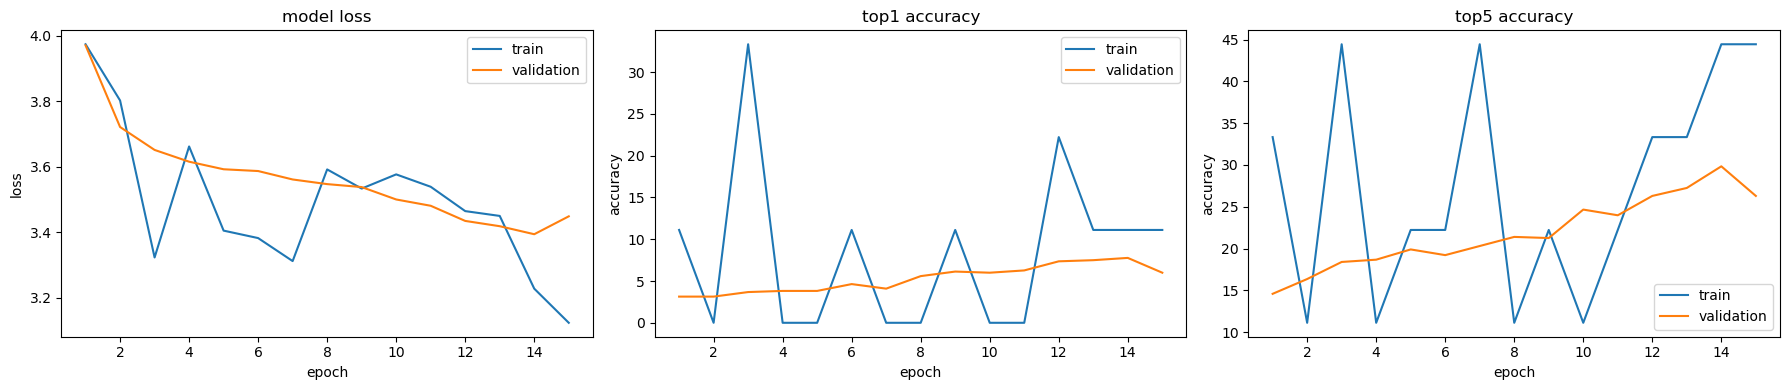

In [67]:
import matplotlib.pyplot as plt

def plot_training_curves(history): 
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)
    
    ax = axes[0]
    ax.plot(history['epoch'], history['losses'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_losses'], label='validation')
    ax.set(
        title='model loss',
        ylabel='loss',
        xlabel='epoch')
    ax.legend()
    
    # ax = axes[1]
    # ax.plot(history['epoch'], history['batch_time'], label='train')
    # ax.plot(history['val_avg_epoch'], history['val_avg_batch_time'], label='validation')
    # ax.set(
    #     title='model batch_time',
    #     ylabel='batch_time',
    #     xlabel='epoch')
    # ax.legend()
    
    
    ax = axes[1]
    ax.plot(history['epoch'], history['top1'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_top1'], label='validation')
    ax.set(
        title='top1 accuracy',
        ylabel='accuracy',
        xlabel='epoch')
    ax.legend()
    
    ax = axes[2]
    ax.plot(history['epoch'], history['top5'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_top5'], label='validation')
    ax.set(
        title='top5 accuracy',
        ylabel='accuracy',
        xlabel='epoch')
    ax.legend()
    fig.tight_layout()
    
plot_training_curves(model_history)